## 시멘틱 세그멘테이션으로 아웃 포커싱 효과 만들기

In [9]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

필요 모듈 import

In [394]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1216, 912, 3)


### 세그멘테이션으로 사람과 배경 분리
인물 사진에서 배경만 다르게 편집하려는 용도로 진행 하는 작업입니다.

---

#### 시멘틱 세그멘테이션(semantic segmentation)
세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 **시맨틱 세그멘테이션** 이라고 합니다.

- 시멘틱 세그멘테이션에 DeepLab 알고리즘 사용

In [395]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

**`preprocess()`**는 전처리, **`run()`**은 실제로 세그멘테이션을 하는 함수입니다. 먼저 input tensor를 만들기 위해 **`preprocess()`** 함수에서 이미지를 전처리 합니다. 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정합니다. 전처리된 이미지는 **`run()`** 함수에서 입력값으로 사용되는 것을 볼 수 있습니다.

---
#### 사전 학습된 가중치 모델 불러오기

In [396]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac27/aiffel/human_segmentation/models
model loaded successfully!


준비한 이미지를 네트워크에 입력합니다.

In [397]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1216, 912, 3) (513, 384, 3) 15


**`original_image`**의 크기는 `(1920, 1440)`이고 **`img_resized`**의 크기는 `(513, 384)`이다.

**`seg_map.max()`**는 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하며,  `15` 이라는 값이 출력 됩니다.

- 아래 영역 추출해서 사람 라벨을 max로 만들어서 15의 값이 출력 되었다.

In [398]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

#### 예측 값 중 사람(person) 라벨의 영역만 추출하기

사람(person)의 라벨 값은 15이다.

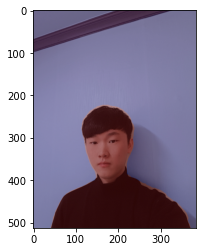

In [399]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.7, color_mask, 0.3, 0.0) # 가중치 부여

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

예측된 세그멘테이션 이미지(map)는 최대값이 15가 됩니다. 
일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. **applyColorMap()** 함수로 색을 적용하고 이미지를 화면에 출력합니다.

### 세그멘테이션 결과를 원래 크기로 복원
DeepLab 모델을 사용하기 위해 이미지 크기를 작게 `resize` 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.

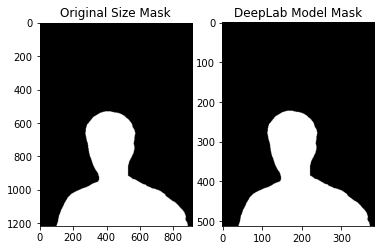

In [400]:
# cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야한다.
# 이미지의 사이즈를 키우니 cv2.INTER_LINEA 옵션을 사용한다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)


ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')


ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

plt.show()


결과적으로 **`img_mask_up`** 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(**`threshold`**)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

---
### 배경 흐리게 만들기
세그멘테이션 마스크를 이용해서 배경만 추출

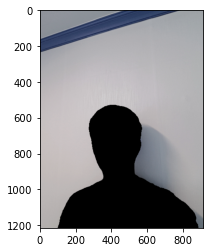

In [401]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 [배경 : 255, 사람 0]
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) #  and 연산으로 배경만 얻기
plt.imshow(img_bg)
plt.show()

위 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있습니다.

- blur의 세기를 다르게 한 2개의 이미지를 만들어서 비교해보기

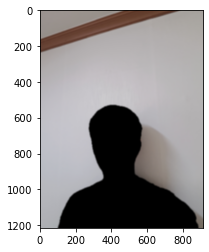

In [412]:
img_bg_blur1 = cv2.blur(img_bg, (10,10))
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

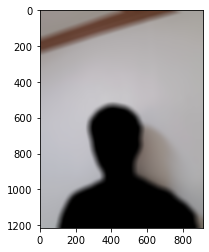

In [413]:
img_bg_blur2 = cv2.blur(img_bg, (40,40))
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

---
### 흐린 배경과 원본 영상 합성


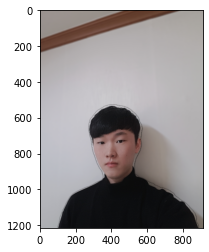

In [414]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur1)
# 이미지를 잘 보면 문제가 있는 부분이 보이는데 그 부분을 되짚어 보기 위해 저장하겠습니다.  
cv2.imwrite('my_image_blur10.jpg',img_concat) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

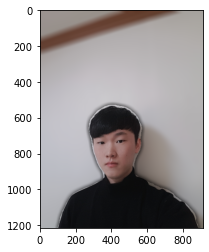

In [405]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur2)
# 이미지 시멘틱 세그멘테이션으로 아웃 포커싱 구현할 때 나타난 문제점 분석 위해 이미지 저장
cv2.imwrite('my_image_blur40.jpg',img_concat) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

blur(40,40)와 같이 값을 크게 줄 수록 배경과 사람의 경계는 더 뚜렷하게 나타나진다.

### 다양한 사진 효과 생성
위의 얼굴사진으로 잘 되는것을 확인했으니 다양한 사진으로 테스트하겠습니다.

- 고양이 사진 (아웃 포커싱 효과)


- 배경전환 크로마키 사진 

#### 고양이 사진 [아웃 포커싱 효과]

In [287]:
# 사진 가져오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.jpeg' 
img_orig = cv2.imread(img_path) 

DeepLabModel 모델과 고양이 이미지를 네트워크에 입력

In [288]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(675, 450, 3) (513, 342, 3) 9


In [289]:
# 고양이의 라벨은 8 입니다.
LABEL_NAMES

['background',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tv']

In [290]:
LABEL_NAMES[8]

'cat'

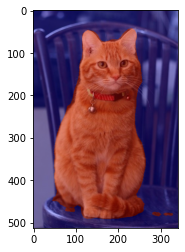

In [291]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.7, color_mask, 0.55, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 결과를 원래 크기로 resize한다.

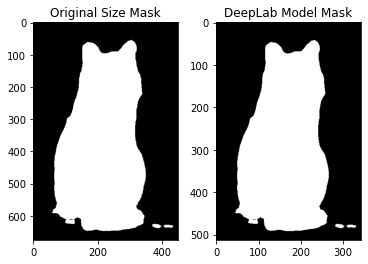

In [292]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_CUBIC)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

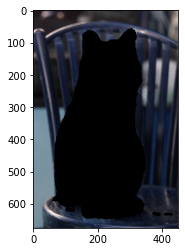

In [293]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 [배경 : 255, 고양이 0]
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) #  and 연산으로 배경만 얻기
plt.imshow(img_bg)
plt.show()

배경만 있는 이미지를 blur처리 해서 아웃 포커싱 효과가 나오게끔 만들어 준다.

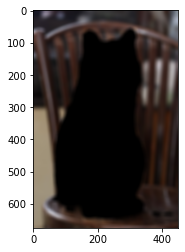

In [294]:
img_bg_blur = cv2.blur(img_bg, (15,15))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

마지막으로 `blur`처리 한 배경과 원본 고양이 이미지를 합치면, 배경은 **아웃 포커싱** 효과와 같이 흐릿하지만, 고양이는 **뚜렷한** 이미지 결과를 얻습니다.

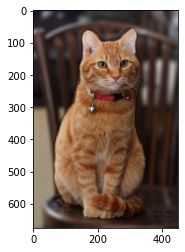

In [295]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 아웃 포커싱 효과가 적용된 고양이 사진이 만들어졌습니다!

### 배경전환 크로마키 사진
고양이를 다른 배경과 합성시켜 봅시다.

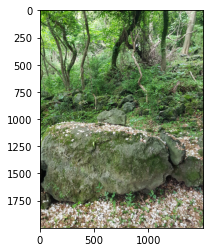

In [286]:
# 사진 가져오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Chroma_Key.png' 
img_ck_bg = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_ck_bg, cv2.COLOR_BGR2RGB))
plt.show()

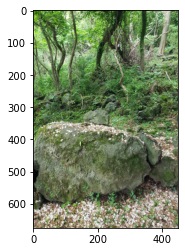

In [299]:
# 이미지 크기를 고양이 이미지와 같은 크기로 resize해준다.
img_ck_bg = cv2.resize(img_ck_bg, img_orig.shape[:2][::-1], interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(img_ck_bg, cv2.COLOR_BGR2RGB))
plt.show()

위의 배경을 가지고 있던 고양이 사진과 합치면 배경전환 크로마키가 된다.

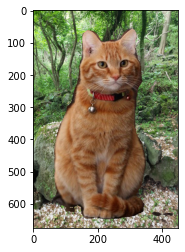

In [301]:
# 새로 가지고온 배경과 고양이를 하나로 보여준다.
img_concat = np.where(img_mask_color==255, img_orig, img_ck_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

가지고 온 배경 이미지에 블러(blur)를 씌우고 싶으면 배경을 `resize()`할 떄블러를 적용하면 된다.

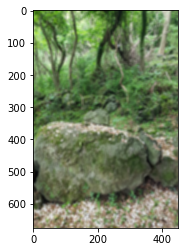

In [308]:
img_ck_bg = cv2.resize(img_ck_bg, img_orig.shape[:2][::-1], interpolation=cv2.INTER_AREA)
img_ck_bg_blur = cv2.blur(img_ck_bg, (8,8))
plt.imshow(cv2.cvtColor(img_ck_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

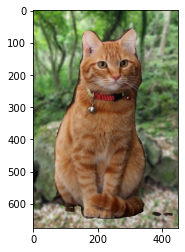

In [309]:
# 배경에 블러(blur)를 적용한 고양이 사진
img_concat = np.where(img_mask_color==255, img_orig, img_ck_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

--- 
마지막으로 강아지사진을 블러(`blur`)처리 해보겠습닌다.

In [313]:
LABEL_NAMES

['background',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tv']

In [319]:
LABEL_NAMES[12]

'dog'

(790, 564, 3) (513, 366, 3) 12


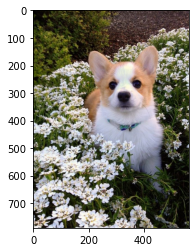

In [337]:
# 사진 가져오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog3.jpeg' 
img_orig = cv2.imread(img_path)

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

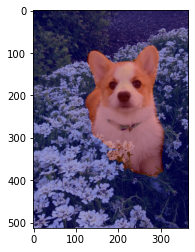

In [338]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 개만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.45, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

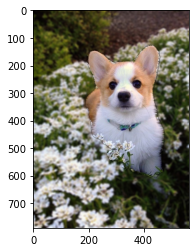

In [342]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_CUBIC)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# image 배경과 객체와의 mask 그리기 
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 [배경 : 255, 고양이 0]
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) #  and 연산으로 배경만 얻기

# 배경 blur처리
img_bg_blur = cv2.blur(img_bg, (8, 8))

# blur처리 한 배경과 원본 이미지를 합친다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.show()

#### 이런식으로 blur 처리할 때는 blur의 값을 낮게 줘야 더 깔끔한 사진이 나오는것 같다.

---
### 위의 방식으로 할 때 생기는 문제점 

- **시멘틱 세그멘테이션**으로 배경과 인물을 분리한 후 배경에만 `blur` 효과를 줘서 카메라에 **shallow focus**와 같은 느낌이 나는 사진을 만들때 생기는 문제점을 알아보겠습니다.

위의 사진과는 다른 blur 작업을 진행한 사진을 가지고 와서 확인해 봅시다.

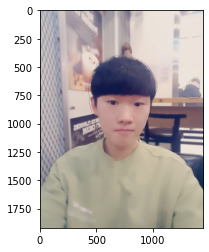

In [365]:
# 프로젝트 폴더 안에 넣어놔서 바로 불러올 수 있습니다.
img_blur_pb10 =  cv2.imread('my_image_blur10.jpg')
plt.imshow(cv2.cvtColor(img_blur_pb10, cv2.COLOR_BGR2RGB))
plt.show()

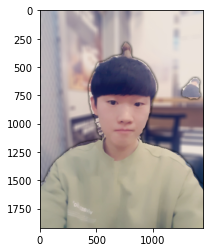

In [366]:
# 프로젝트 폴더 안에 넣어놔서 바로 불러올 수 있습니다.
img_blur_pb40 =  cv2.imread('my_image_blur40.jpg')
plt.imshow(cv2.cvtColor(img_blur_pb40, cv2.COLOR_BGR2RGB))
plt.show()

이러한 문제는 `blur`값을 크게 줬을때 더 명확하게 잘보이는데,  

1. 좁은 범위에서 제대로 경계가 세밀하게 안그려지는 문제

2. 내 몸에 접하거나 접한것처럼 보이는 다른 객체도 내 몸이라 판단하는 문제

3. 영상에 만약 다른 사람이라고 판단되는 부분이 있으면 그 사람 까지 포함하는 문제

- 위와 같은 문제는 아래와 같이 세그멘테이션 mask를 씌웠을때로 보면 더 잘보입니다.

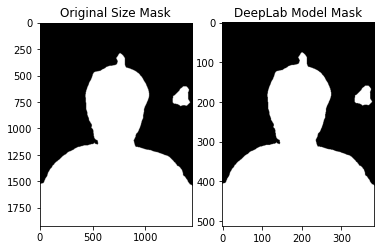

In [349]:
# cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야한다.
# 이미지의 사이즈를 키우니 cv2.INTER_LINEA 옵션을 사용한다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)



ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')


ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

plt.show()


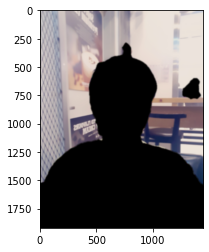

In [378]:
img_bg_blur1 = cv2.blur(img_bg, (10,10),0)
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

위의 **Segmentation mask** 결과들을 보면 사람의 형상으로 경계가 그려지긴 하지만 주변에  
**`다른 개체 `**들도 **`같은 개체`**라고 판단해서 **경계**가 그려진것을 볼 수 있다.

문제가 발생한 부분들을 사진에 직접 표시하자면 다음과 같다.

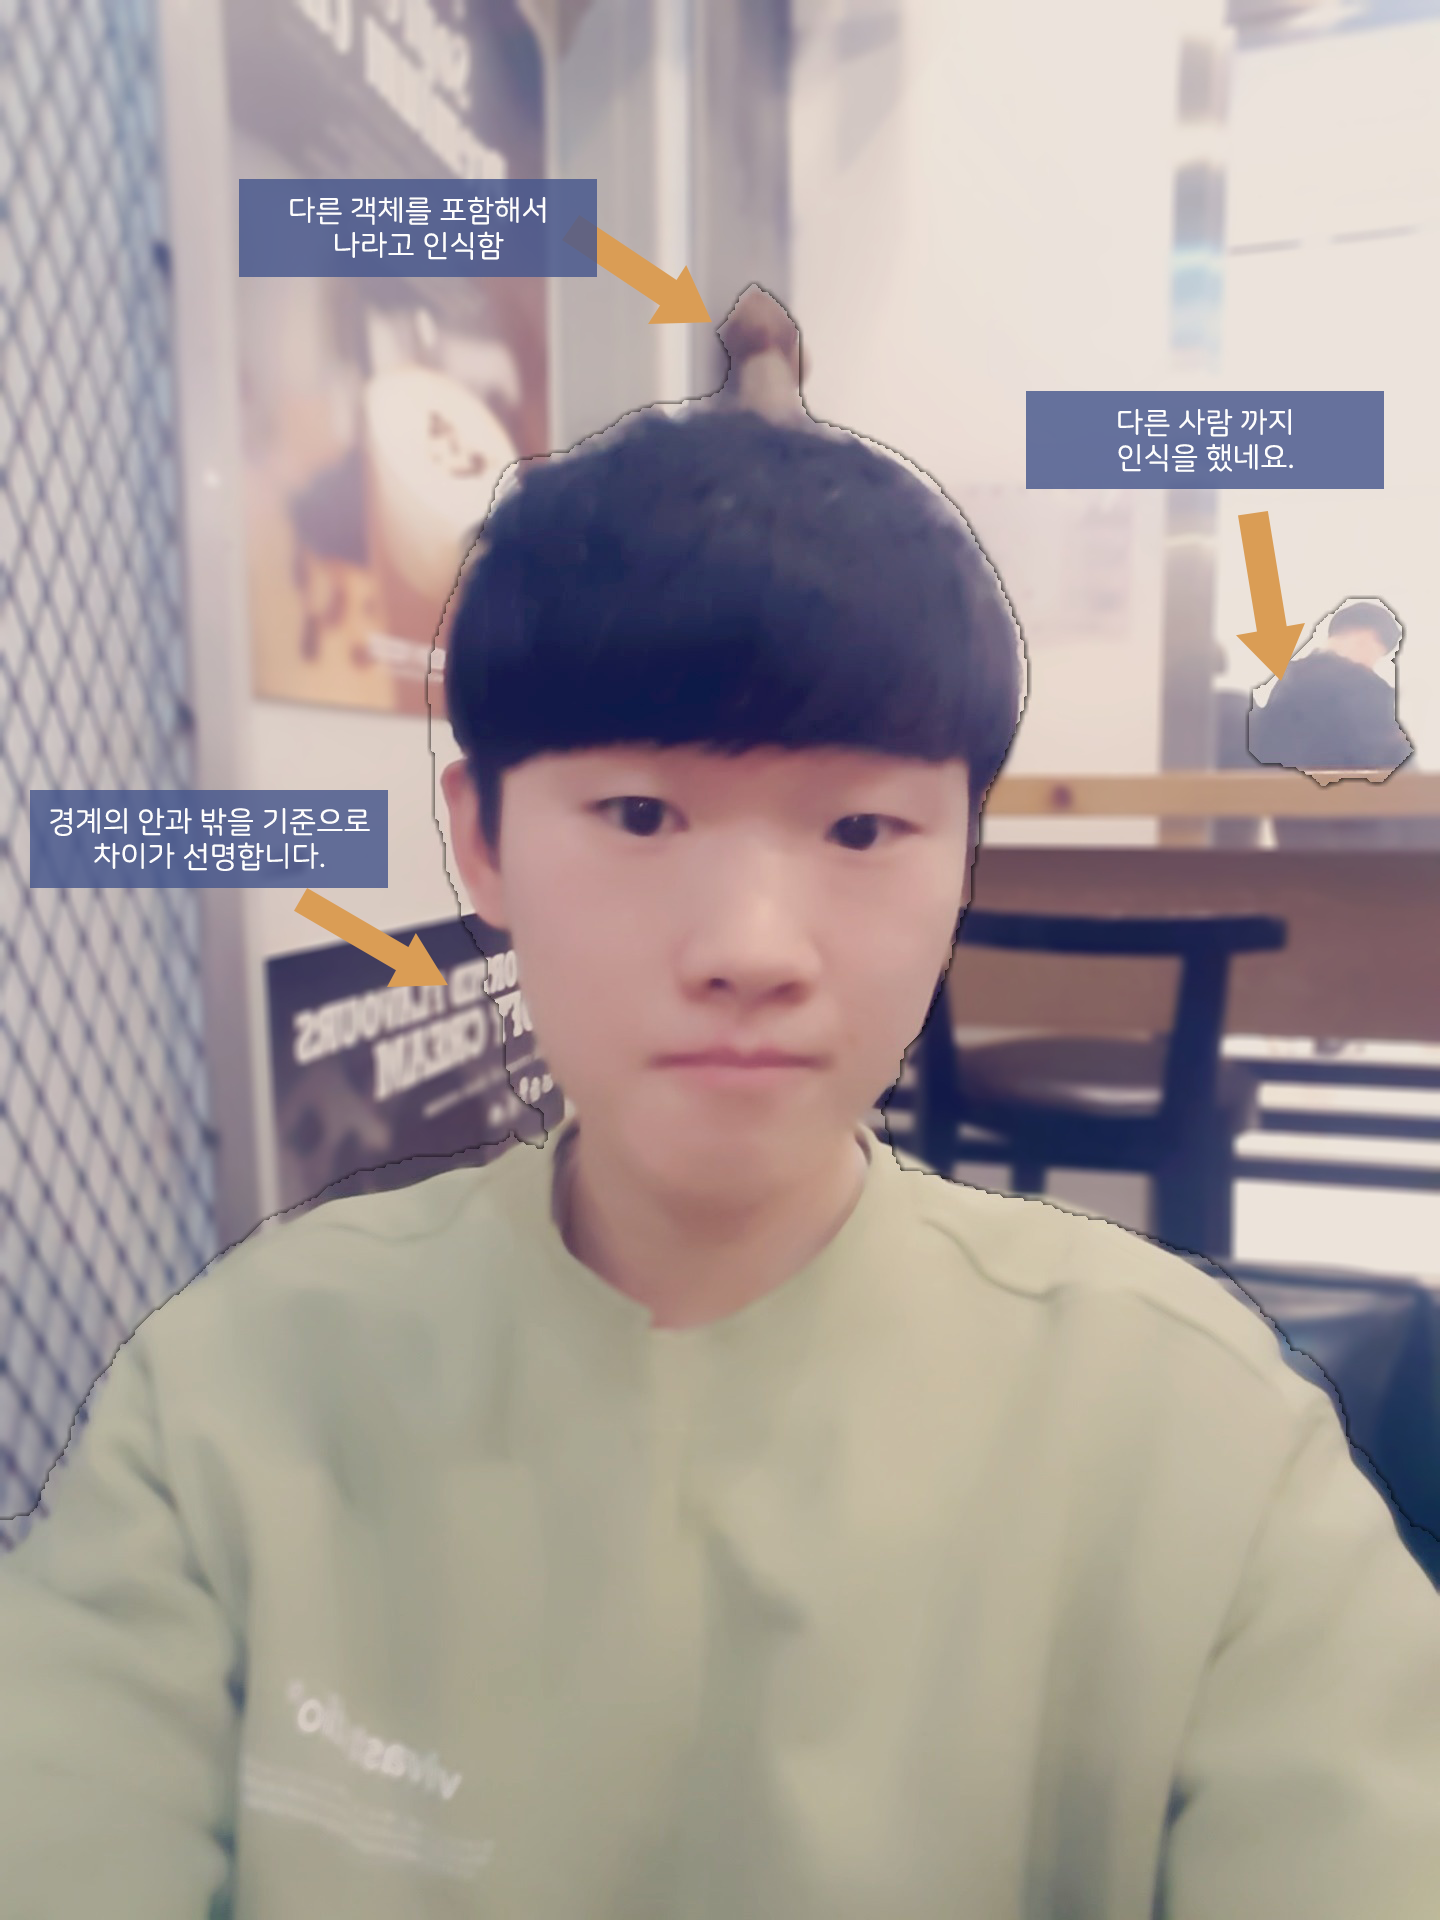

---
### Semantic segmentation을 활용한 사진 구분 요약

위의 문제를 보면 핵심은 **`Semantic segmentation`**의 부정확성이 이러한 문제를 일으킨다.
그리고 이러한 부정확성을 일으키는 요인으로는 **`Semantic segmentation`**이 사진에 개체를 구분할 때 그 **개체의 위치에 대한 정보**가 없기에 나보다 뒤에 있는 어느 한 부분을 나와 같은 위치에 있다고 판단해서 생기는 문제들이 사진에서 나타난 것이다.

#### 따라서 해당 문제를 해결하기 위해 기존과는 다른 픽셀이 가지는 정보가 필요하다.  
즉, 픽셀의 깊이 값을 계산할 수 있는 기술들을 활용하여 `Semantic segmentation`문제를 해결할 수 있다.

---
### Semantic segmentation의 한계로 발생하는 문제 솔루션

#### 사진에서 생겼던 문제  
1. 멀리 떨어진 물체를 몸과 같은 위치로 판단해서 사람이라고 인식해서 Mask를 씌운 문제

2. 멀리 떨어진 사람도 같이 찍힘

3. Semantic segmentation이 정교화게 안되었음

- 1,2,3번 같은 경우 모두 거리에 대한 값을 구할 수 있으면, 해결할 수 있어 보인다.


멀리 특정 거리를 기준으로 보다 멀리 떨어져 있으면, 아웃 포커싱이 적용할 대상이 아닌것으로 하면 위의 문제는 해결이 된다.   
  3번의 경우도 마찬가지로 위의 사진에서 찍힌 '사람'과 나머지 배경을 보면 실제로 거리가 상당히 떨어져 있기에 Mask를 더 정교하게 그릴 수 있다.

#### 위의 사진알 수 있는 핵심적인 문제

Semantic segmentation도 결국 픽셀이 가지는 깊이 정보를 알 수 없기에 생기는 문제이다.  
따라서 이를 해결할 방법으로는 적외선 방식, 스테레오 방식, ToF 방식 그리고 구글에서 발표한 struct2depth 방식이 있지만 이 중에서 TOF 방식을 문제 해결 솔루션으로 생각했습니다.


#### TOF 방식의 원리
- TOF 방식의 기본 원리 :  빛을 쏘아서 반사되어 오는 시간을 측정하여 거리를 계산합니다.  


- TOF 방식의 핵심적인 원리 : LED 발신부에서는 빛을 쏠 때 굉장히 빠른 간격으로 점멸을 시키면서 즉, 모듈레이션(modulation)을 시키면서 쏘고 수신부에서는 이 모듈레이션 간격과 동기화하여 receptor들을 활성화시키는 것입니다. 여기서 LED를 켜는 동안은 in phase라 부르고 LED를 끄는 동안은 out phase라 부릅니다.

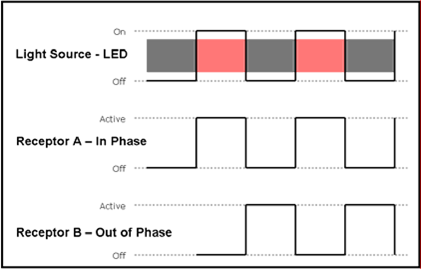

즉, 위 그림과 같이 LED를 켜는 동안에는 in phase receptor들만을 활성화시키고, LED를 끌 동안에는 out phase receptor들만을 황성화시킵니다.


이와 같이 in phase receptor들과 out phase receptor들을 시간차를 두고 서로 다르게 활성화시키면 사물과의 거리에 따라서 수신되는(누적되는) 빛의 양에 차이가 발생하게 됩니다. 이 차이 즉, in phase receptor에 수신된 빛의 양과 out phase receptor에 수신된 빛의 양의 차이를 비교하여 사물과의 거리를 측정하는게 TOF 카메라의 기본 원리입니다.

- [내용 참고 : https://darkpgmr.tistory.com/75]

#### 솔루션으로 TOF 방식을 선택한 이유
성능이 뛰어나고 스테레오 방식보다 더 나은 해상도를 가지고 있습니다.

1. 삼성과 Apple에서도 3D depth를 구하는 중요한 차세대 기술로 생각하고 있습니다. 
  - 참조 1 : **[iPhone 2020 to Use Time of Flight Sensor](https://www.youtube.com/watch?v=PqI41pEY7i8&feature=emb_logo)**  
  - 참조 2 : **[애플 아이폰12프로 라인업, ToF 첫 탑재](http://www.thelec.kr/news/articleView.html?idxno=8171)**
  - 참조 3 : **[스마트폰 ToF 센서의 부활… 최신 스마트폰 탑재 전망](https://www.sentv.co.kr/news/view/580727)**
  
  
2. 현재 곽광받는 기술이며, 솔루션의 목적이 더 나은 사진이기에 좋은 해상도를 얻을 수 있는 TOF방식을 생각합니다.

### TOF방식을 적용한 매커니즘

위의 기본적인 2D사진의 진행 방식은 사진에서 사람인 부분을 Mask 씌운 후 보케(아웃포커싱)을 진행해서 해당 인물과의 다른 사물과의 거리에 대한 위치 정보는 신경을 쓰고 있지 않습니다. 그에 따라서 먼 거리에 있는 머리위에 버섯같은 것을 저의 위치와 같다고 여깁니다.  

결국 이 문제를 해결하기 위해 다음과 방식을 생각했습니다.  

---
1.  Semantic Segmentation의 person label의 Mask영역을 뽑습니다.  


2. 해당 Mask 영역만을 가지고 ToF 방식으로 아래의 사진과 같이 Depth Image를 얻습니다.
   - Depth Image에서 픽셀들이 가지고 있는 값은 0-1로 정규화 시켜 줍니다.  <br>(멀 수록 1에 가까워집니다.)
   
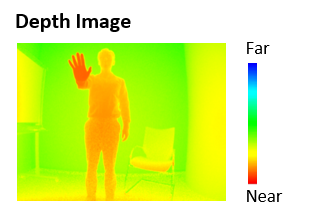

**[출처 : https://kagafeieurope.com/products/systems/time-of-flight-camera/]**

3. **사람**이라고 인식한 Mask에서 Depth Image의 픽셀들이 가지는 위치 값들 중 다른 위치 값에 비해 더 멀리 떨어진 (보다 1에 크게 가까운) 이상치 데이터를 제외한 영역(mask)를 찾습니다.


4. 3에서 찾은 영역을 가지고 원본 이미지에서 사람과 배경을 분리 합니다.


5. 배경만 있는 이미지에 보케(아웃포커싱) 효과를 내기 위한 blur 처리를 하고 mask된 이미지를 합치면 기존의 Semantic Segmentation만 사용한 방식보다 더 정교한 **인물 사진 효과** 줄 수 있게 됩니다.

--- 

###  회고

- 지금까지는 어느정도 정답이란게 있는 주어진 방법으로만 생각을 해보고 거기서 좀 더 벗어나서 더 나은 방식, 더 나은 해결책을 생각하지 않았는데 이번에 프로젝트를 진행하면서 **'주어진 문제에서 더 나은 방식이 어떤게 있는지'** , **'더 나은 방식이 있다면 어떻게 접목시키는게 좋은지'**를 생각해 볼 수 있어서 더 공부가 되었던 프로젝트 였습니다.  


- 솔루션 방식으로 3D 카메라를 생각하면서 정보를 찾았는데 그 과정에서 몰랐었던 3D 카메라 기술이 이미 활발하게 연구가 되고 있는 것과 스마트폰에 tof 기술이 적용이 되어 있는것을 보고 놀랐습니다.


- 삼성의 경우 갤럭시S10 부터 이미 위의 TOF를 활용하였지만 노트 20부터 다시 사용하지 않았고 Apple 같은 경우 이번에 TOF를 적용한 아이폰 12 pro를 내놨는데 이 두 업체의 전략이 나중에 어떻게 판가름날지도 궁굼하네요.  


- 그리고 추가적으로 AR과 VR에서 앞으로 중요하게 여겨질 기술을 알게 되어서 좀 더 배울 수 있었던 시간이었던 것 같습니다.